# One time setup for use in labs.iot-lab.info

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib

---


Prerequisites:

- Connect to this Jupyter lab instance https://labs.iot-lab.info
- Clone the enoslib tutorias source: `git clone https://gitlab.inria.fr/msimonin/enoslib-tutorials` at the root of the jupyter lab instance
- Open this notebook at `enoslib-tutorials/`

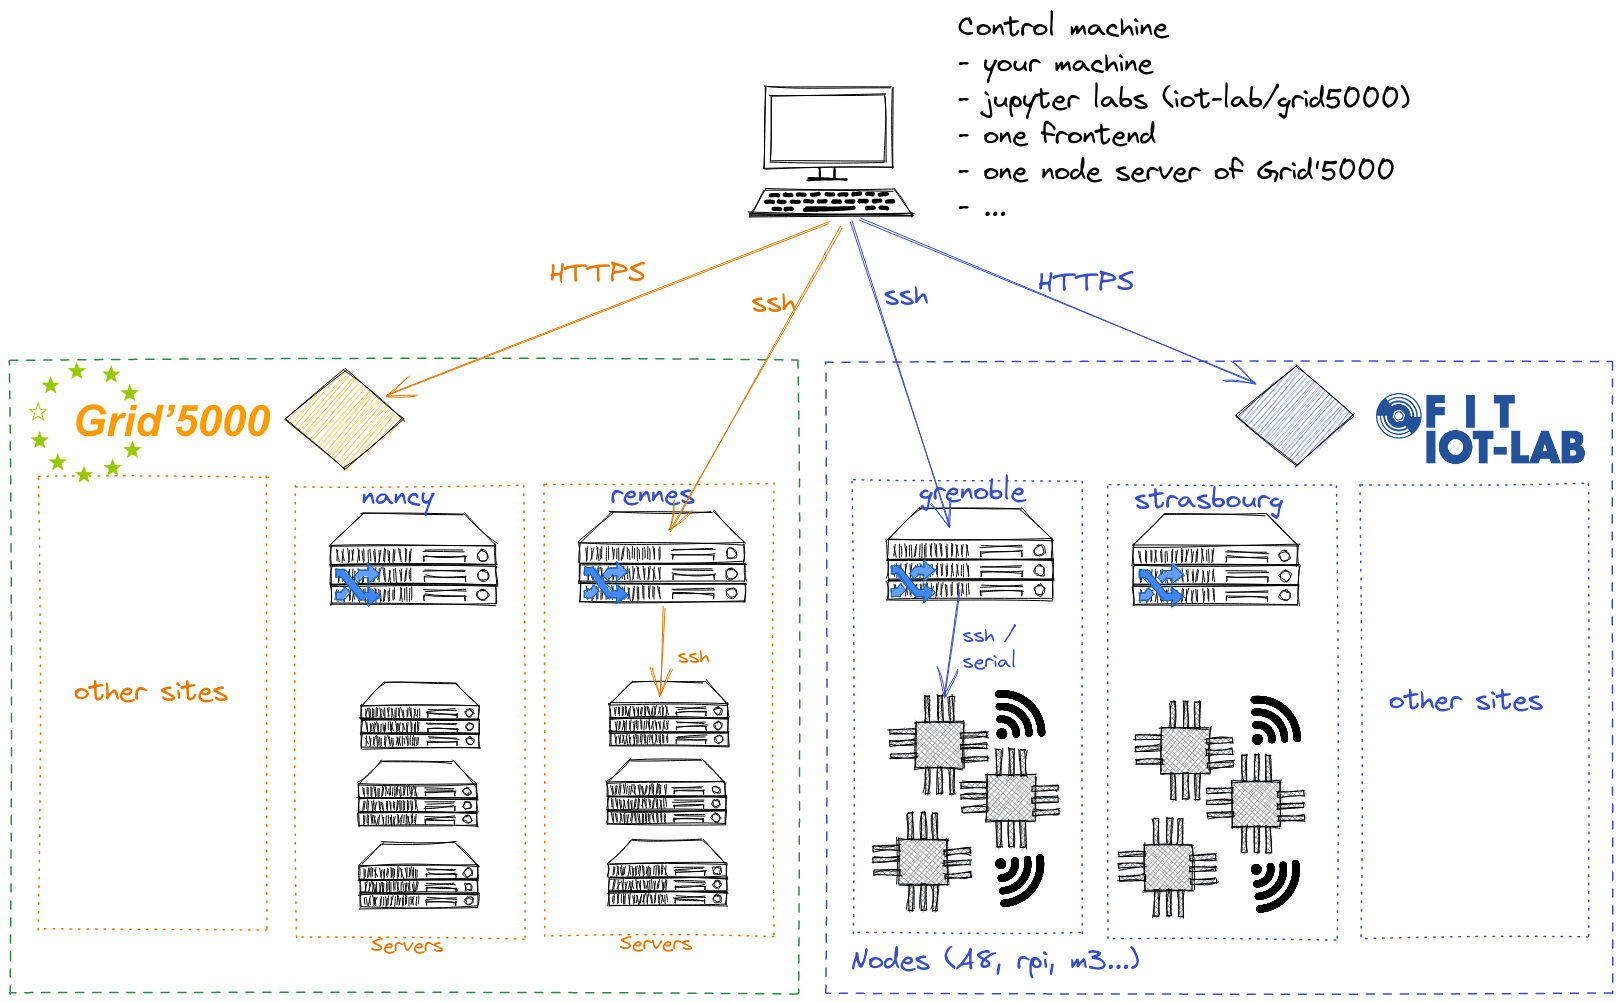

In this setup the control machine is the jupyter instance running at  https://labs.iot-lab.info

## Software dependencies

First things first, you'll need EnOSlib library to go through this tutorial.

- Launch the following
- Restart the kernel

In [ ]:
!pip install -U pip

# pick one
# latest stable
# !pip install -U --user enoslib[silecs]

# latest alpha version
# !pip install -U --user --pre  enoslib[silecs]

# master version (might be wild)
!pip install  -U --user enoslib[silecs]@git+https://gitlab.inria.fr/discovery/enoslib@dev/hostsview

In [ ]:
# This must not fail (restart the kernel after installing the library)
import enoslib as en

### Setup access to Grid'5000 

We need two kind of accesses to the Grid'5000 platform:
- REST API Access to interact with  Grid'5000 exposed resources (jobs, nodes, networks, firewall ....)
- SSH Access to control the remote machine once acquired

---
#### REST API Access
The REST API access is performed using HTTP request using BasicAuth Authentication mecanism through the [`python-grid5000`](https://pypi.org/project/python-grid5000/) wrapper.
This requires to store the username/password in a file located in your home directory.

In [ ]:
from grid5000.cli import auth
# CHANGE ME!
G5K_USER = "msimonin"
# will prompt for the password and write the authentication file
auth(G5K_USER)

In [ ]:
# Test the api access
from grid5000 import Grid5000
from pathlib import Path
conf_file = Path.home() / ".python-grid5000.yaml"
gk = Grid5000.from_yaml(conf_file)
gk.sites.list()

In [ ]:
# have some fun with the g5k python client ... 
gk.sites["rennes"].clusters.list()

In [ ]:
print(gk.sites["rennes"].clusters["paradoxe"].nodes.list()[0])

---
#### SSH access 
The SSH access relies on SSH key authentication.
Add the content of the public key in the Grid'5000 interface in [your Grid'5000 account](https://api.grid5000.fr/stable/users/) > ssh_keys

In [ ]:
!cat ~/.ssh/id_rsa.pub

<div class="alert alert-block alert-warning">
    Note that you don't own the corresponding private key, so that's probably better to remove it from <a href="https://api.grid5000.fr/stable/users/">your Grid'5000 account</a> as soon as possible.
</div>

#### Set a SSH config to ease the connection to G5K

For instance this eases the direct connection to unconstrained node (A8, Rpi ...) that run a SSH server.

In [ ]:
from pathlib import Path

config = Path.home() / ".ssh/config"

# Access to machines inside G5K
config_g5k = f"""Host !access.grid5000.fr *.grid5000.fr
   User {G5K_USER}
   ProxyJump {G5K_USER}@access.grid5000.fr
   StrictHostKeyChecking no
   UserKnownHostsFile /dev/null
   ForwardAgent yes
   
   Host access.grid5000.fr
   User {G5K_USER}
   StrictHostKeyChecking no
   UserKnownHostsFile /dev/null
   ForwardAgent yes
"""


FIT_USER = "simonin"
configs_iot = []
for site in ["grenoble", "lille", "saclay", "strasbourg"]:
    configs_iot.append(f"""Host !{site}.iot-lab.info *.{site}.iot-lab.info
   User {FIT_USER}
   ProxyJump {FIT_USER}@{site}.iot-lab.info
   StrictHostKeyChecking no
   UserKnownHostsFile /dev/null
   ForwardAgent yes
   
   Host {site}.iot-lab.info
   User {FIT_USER}
   StrictHostKeyChecking no
   UserKnownHostsFile /dev/null
   ForwardAgent yes
"""
)

configs = [config_g5k] + configs_iot
config.write_text("\n".join(configs))

In [ ]:
# This must work
!ssh rennes.grid5000.fr hostname

In [ ]:
# Testing the ssh connection to g5k using the  lib
import enoslib as en

en.init_logging()

frontend = en.Host("rennes.grid5000.fr", user=G5K_USER)

r = en.run_command("hostname", roles=frontend, raw=True)

print(f"We've succesfully reached {r[0].stdout}")

In [ ]:
# This also must work
!ssh grenoble.iot-lab.info hostname

In [ ]:
fit_grenoble = en.Host("grenoble.iot-lab.info", user=FIT_USER)

r = en.run_command("hostname", roles=fit_grenoble, raw=True)

print(f"We've succesfully reached {r[0].stdout}")

In [ ]:
# you're ready ! 

## Check

In [ ]:
en.check()